Notebook with trajectories and RNA velocity

In [1]:
import scanpy as sc
import scanpy.external as sce
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler

import scvelo as scv

In [2]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
scv.settings.set_figure_params('scvelo')
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()
scv.__version__

scanpy==1.4.3+116.g0075c62 anndata==0.6.22.post2.dev80+g72c2bde umap==0.3.9 numpy==1.17.2 scipy==1.3.0 pandas==0.24.1 scikit-learn==0.21.3 statsmodels==0.10.0rc2 python-igraph==0.7.1 louvain==0.6.1


'0.1.24.dev7+ge45a65a'

# User input

In [3]:
adata_full_noCC = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/ipsc_ipd_patients_full_noCC.h5ad'

adata_final = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/ipsc_ipd_patients_final.h5ad'

adata_full_noCC_velo = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/ipsc_ipd_patients_full_noCC_scvelo.h5ad'

adata_velo_slim_diffxpy = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/ipsc_ipd_patients_nsc_cell_fate_labs.h5ad'

#adata_mnn_final_velo = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/neuronal_diff_patients_full_mnn_final_scvelo_dyn.h5ad'

folder = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/'

marker_genes_base = 'intermediate_data/mnn_noCC_marker_genes_louvain'

velocyto_folder = '/home/icb/malte.luecken/datasets/raw/20190117_Wurst_Demuxlet_malte.luecken/velocyto/'


# Read in data

In [4]:
adata = sc.read(adata_full_noCC, cache=True)

In [5]:
adata

AnnData object with n_obs × n_vars = 30557 × 24920 
    obs: 'Demux_state', 'Donor', 'Lane', 'Number of genes', 'Total counts', 'age', 'condition', 'donor', 'gender', 'log_counts', 'mt_frac', 'n_counts', 'n_genes', 'size_factors', 'total_counts', 'years_of_illness', 'S_score', 'G2M_score', 'phase', 'louvain_r1', 'louvain_r0.5', 'louvain_r0.2', 'score', 'louvain_r0.2_0_sub', 'louvain_r0.2_0_4_sub', 'louvain_r0.2_0_3_sub', 'dpt_pseudotime', 'louvain_r0.2_noCC', 'louvain_r0.2_noCC_3_sub', 'condition_val', 'apop_score_corr', 'Ferroptosis_pos_corr', 'Ferroptosis_neg_corr', 'Apoptosis_pos_corr', 'Apoptosis_neg_corr', 'Necroptosis_pos_corr', 'Autophagy_pos_corr', 'Pathanatos_pos_corr', 'louvain_r0.2_noCC_NCSC_sub', 'louvain_r0.2_noCC_NCSC1_sub', 'test_groups'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Donor_colors', 'condition_colors', 'gender_colors', 'louvain', 'louvain_r0.2_0_3_sub_colors', 'louvain_r0.2_0_4_sub_colors', 'louvain_r0.2_0_sub_colors', 'l

In [6]:
adata_final = sc.read(adata_final, cache=True)
adata.obs['louvain_final'] = adata_final.obs['louvain_final']

# Trajectories

## PAGA

In [7]:
sc.tl.paga(adata, groups='louvain_r0.2_noCC')

running PAGA
    finished (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


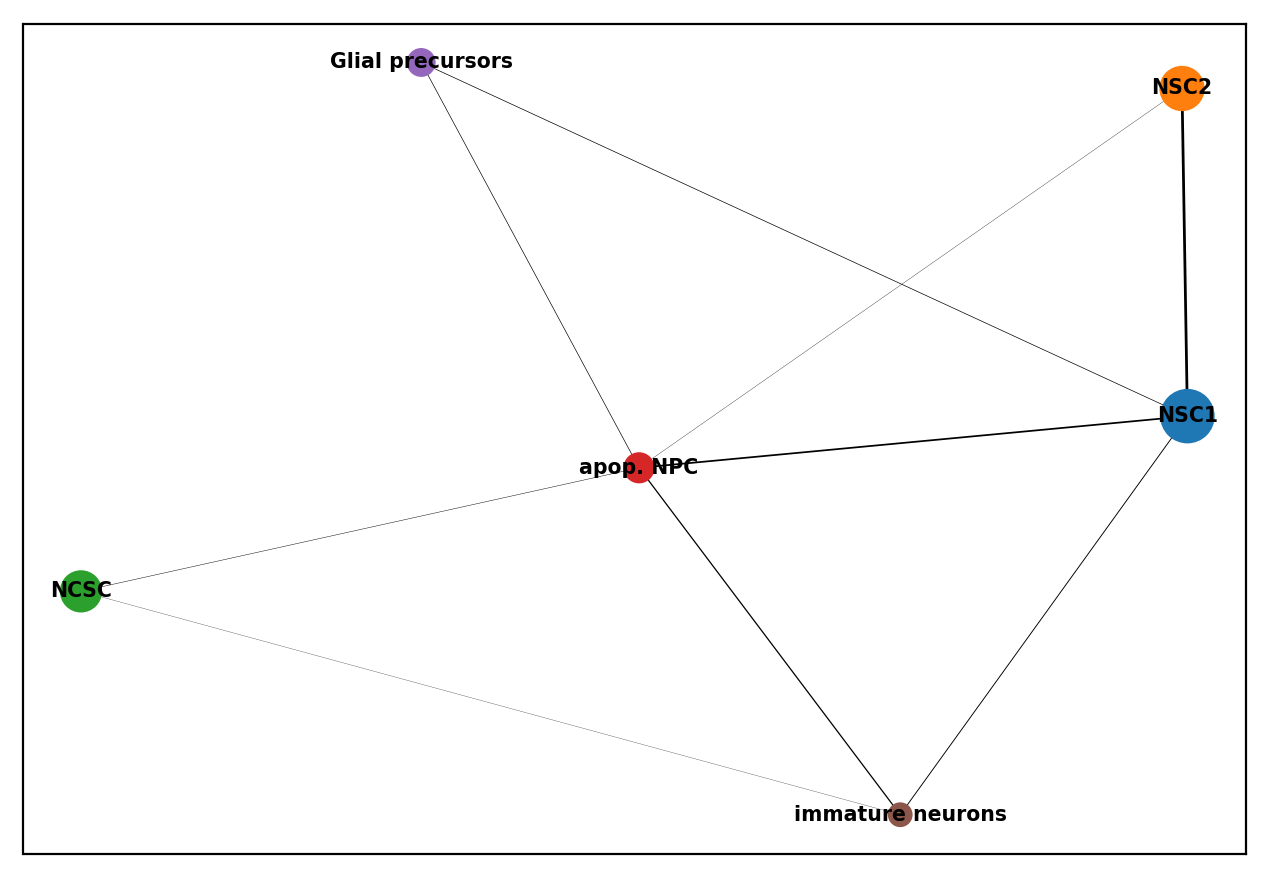

In [8]:
sc.pl.paga(adata)

--> added 'pos', the PAGA positions (adata.uns['paga'])


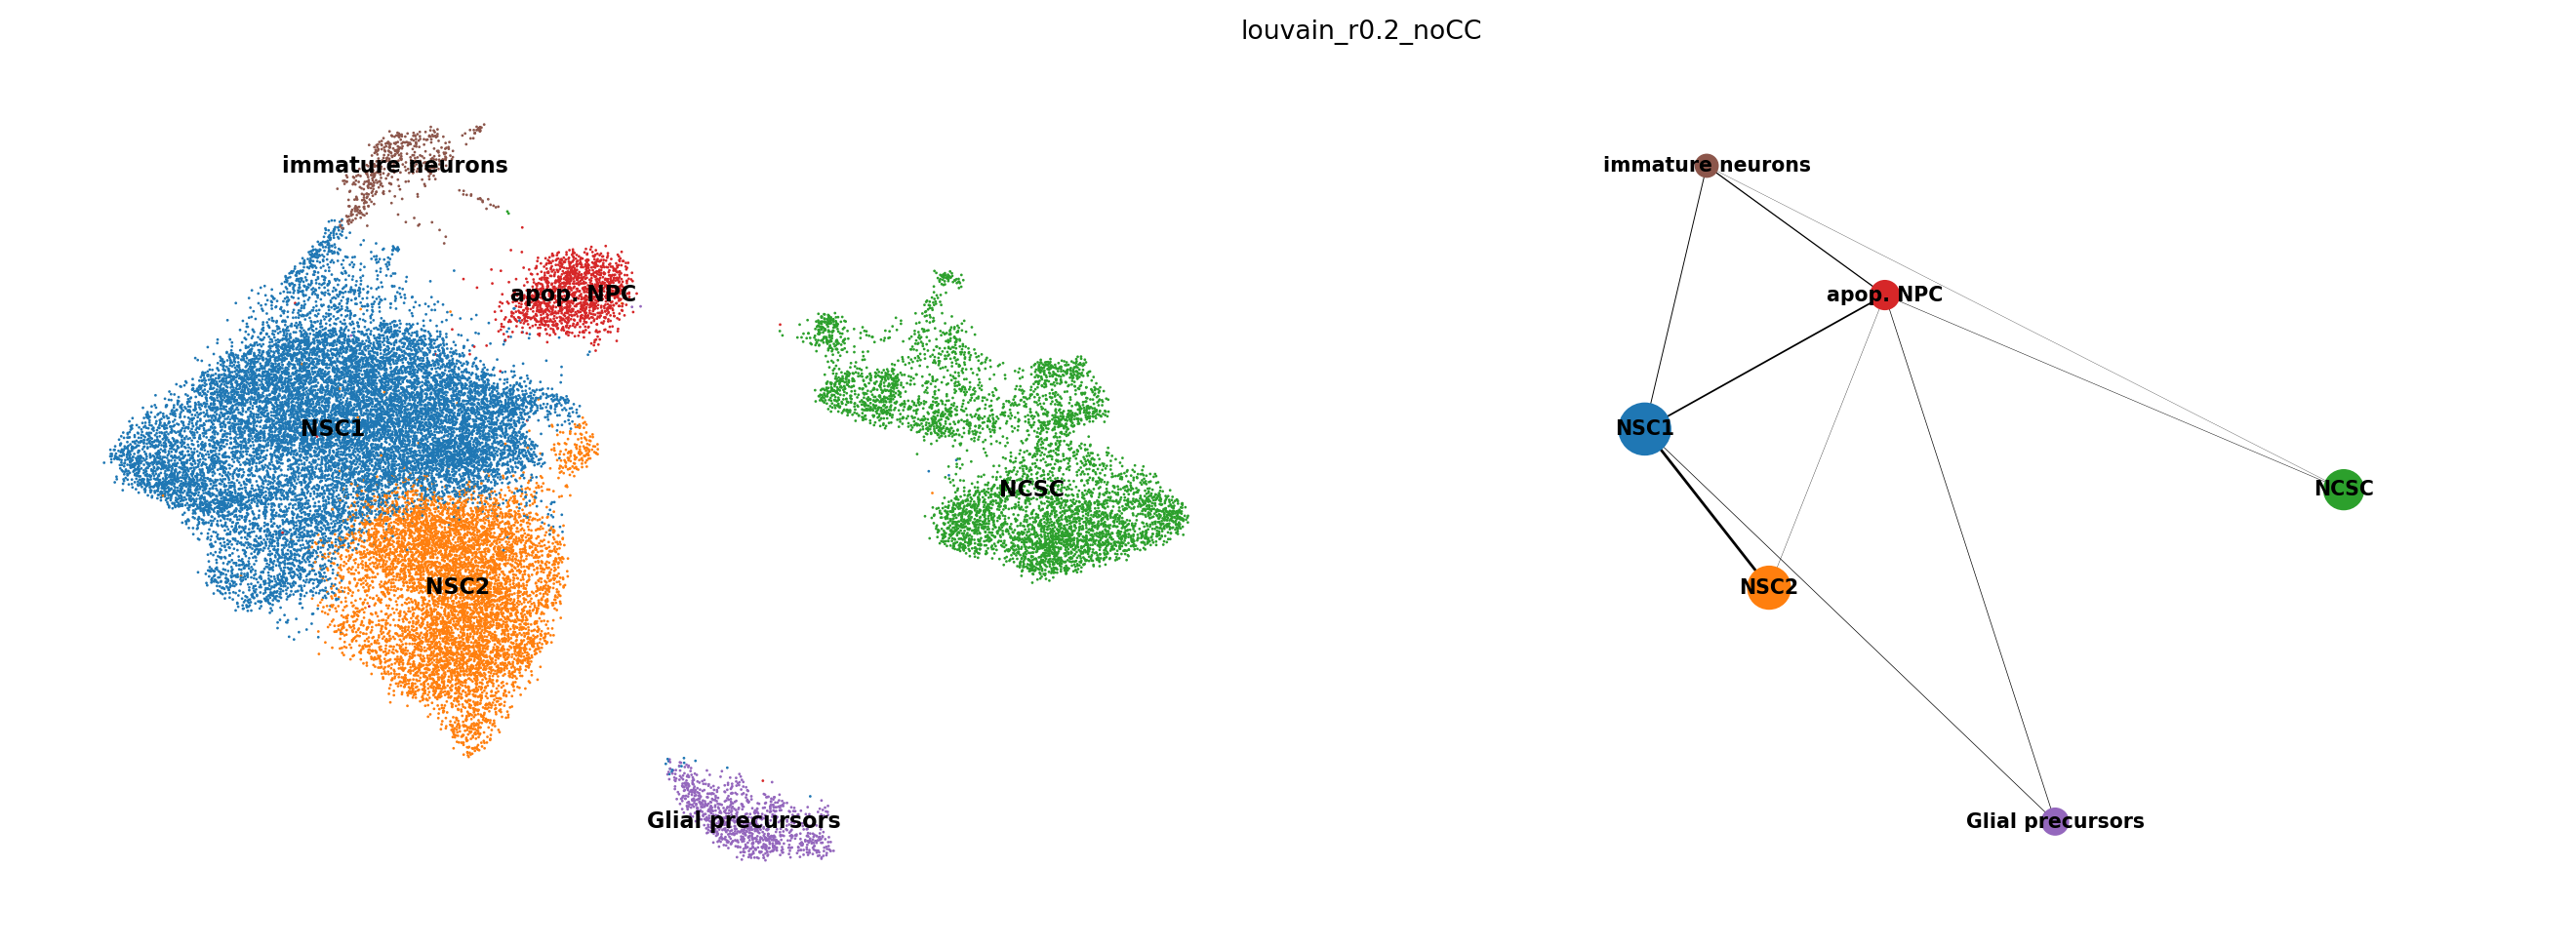

In [9]:
sc.pl.paga_compare(adata, basis='umap')

--> added 'pos', the PAGA positions (adata.uns['paga'])


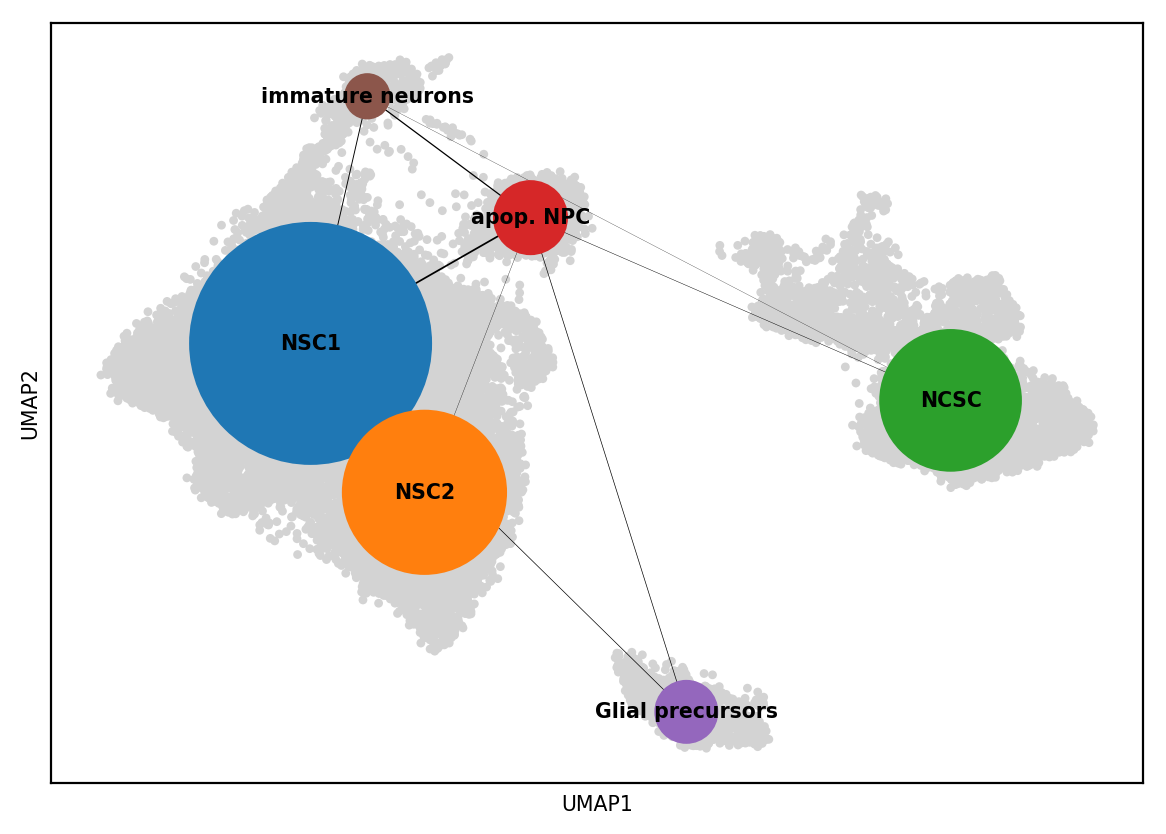

In [10]:
fig1, ax1 = plt.subplots()
sc.pl.umap(adata, size=40, ax=ax1, show=False)
sc.pl.paga(adata, pos=adata.uns['paga']['pos'], show=False, node_size_scale=10, node_size_power=1, ax=ax1)
plt.show()

## DiffMaps & DPT

In [11]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99842715 0.994079   0.9926285  0.9881258  0.98189735
     0.97941375 0.9733626  0.9692381  0.9625023  0.95571315 0.95020527
     0.945846   0.9443146  0.9424456 ]
    finished (0:00:00)


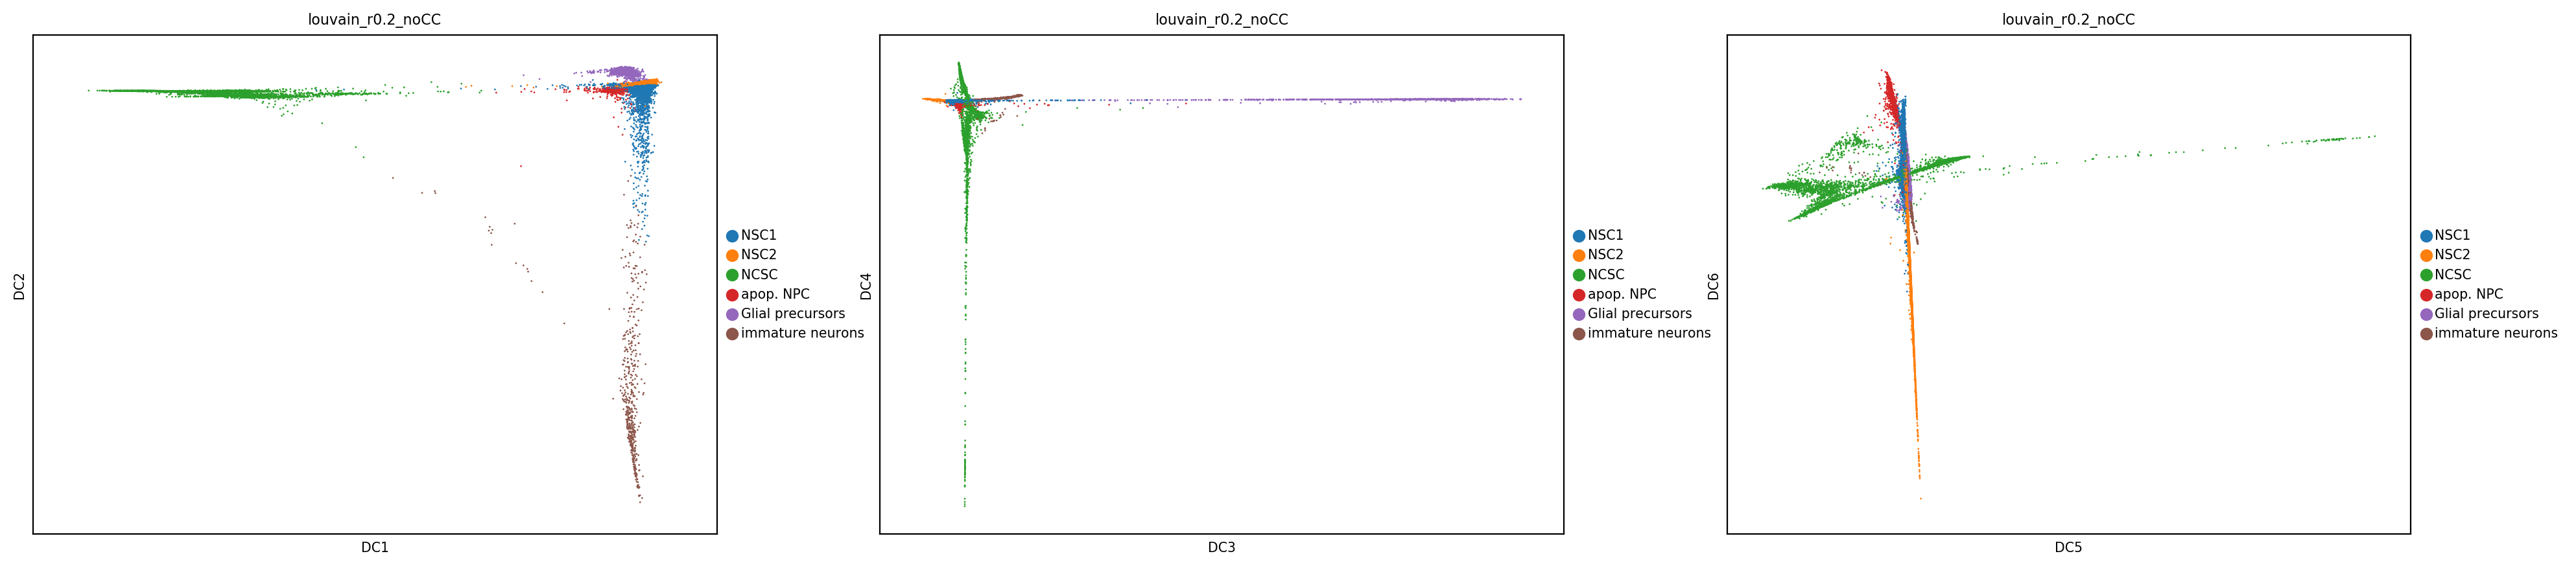

In [12]:
sc.pl.diffmap(adata, components=['1,2','3,4','5,6'], color='louvain_r0.2_noCC')

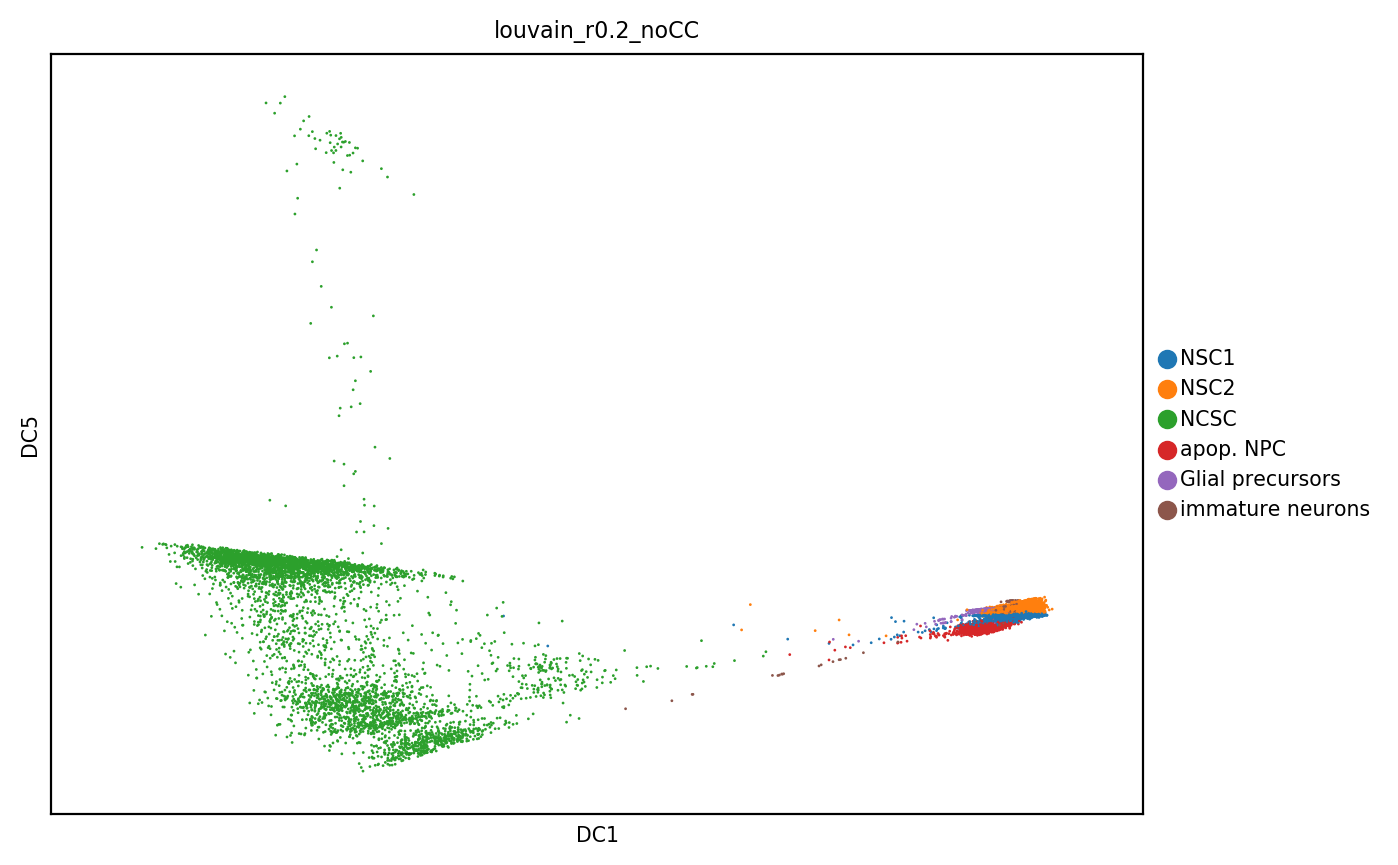

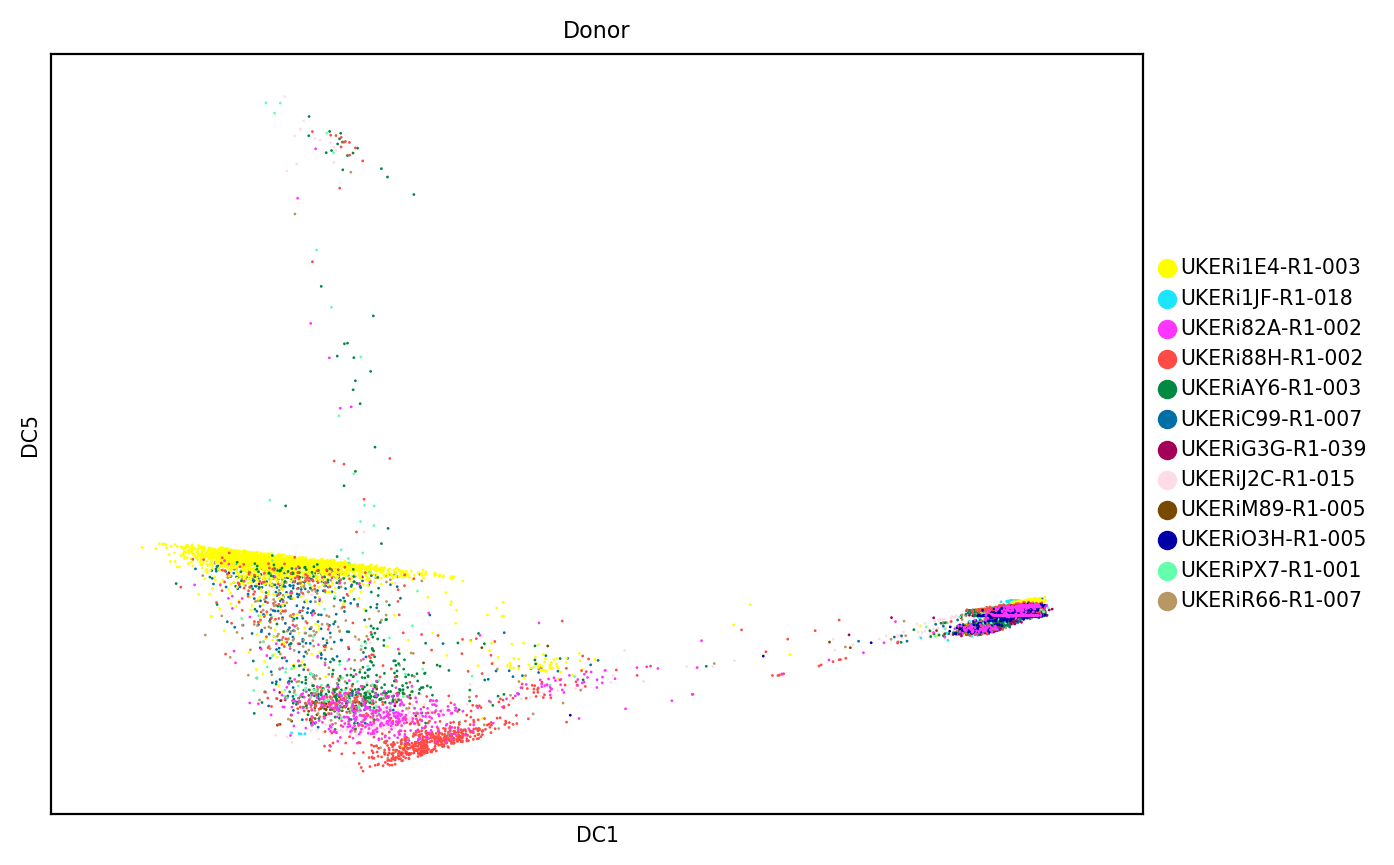

In [13]:
sc.pl.diffmap(adata, components=['1,5'], color='louvain_r0.2_noCC')
sc.pl.diffmap(adata, components=['1,5'], color='Donor')

Notes:
- looks like there is no connection to NCSC from the NSC clusters

Instead:
- subset to main NSC, NPC, neuron cluster

# RNA Velocity

## Read in loom files

In [14]:
files = !ls $velocyto_folder | grep loom

In [15]:
files

['possorted_genome_bam_4I0K6.loom',
 'possorted_genome_bam_5RIA8.loom',
 'possorted_genome_bam_J645L.loom',
 'possorted_genome_bam_OL1XE.loom',
 'possorted_genome_bam_WHHHW.loom',
 'possorted_genome_bam_XZ6CH.loom']

In [16]:
#Read in data
ldata = scv.read(velocyto_folder+files.pop(0), cache=True)
ldata.var_names_make_unique()

... reading from cache file cache/home-icb-malte.luecken-datasets-raw-20190117_Wurst_Demuxlet_malte.luecken-velocyto-possorted_genome_bam_4I0K6.h5ad


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [17]:
for file in files:
    print(f'Reading file: {file}')
    tmp = scv.read(velocyto_folder+file, cache=True)
    tmp.var_names_make_unique()
    
    scv.utils.strings_to_categoricals(ldata)
    
    ldata = ldata.concatenate(tmp, index_unique=None)
    ldata.obs.drop(columns=['batch'], inplace=True)


Reading file: possorted_genome_bam_5RIA8.loom
... reading from cache file cache/home-icb-malte.luecken-datasets-raw-20190117_Wurst_Demuxlet_malte.luecken-velocyto-possorted_genome_bam_5RIA8.h5ad


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading file: possorted_genome_bam_J645L.loom
... reading from cache file cache/home-icb-malte.luecken-datasets-raw-20190117_Wurst_Demuxlet_malte.luecken-velocyto-possorted_genome_bam_J645L.h5ad


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading file: possorted_genome_bam_OL1XE.loom
... reading from cache file cache/home-icb-malte.luecken-datasets-raw-20190117_Wurst_Demuxlet_malte.luecken-velocyto-possorted_genome_bam_OL1XE.h5ad


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading file: possorted_genome_bam_WHHHW.loom
... reading from cache file cache/home-icb-malte.luecken-datasets-raw-20190117_Wurst_Demuxlet_malte.luecken-velocyto-possorted_genome_bam_WHHHW.h5ad


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading file: possorted_genome_bam_XZ6CH.loom
... reading from cache file cache/home-icb-malte.luecken-datasets-raw-20190117_Wurst_Demuxlet_malte.luecken-velocyto-possorted_genome_bam_XZ6CH.h5ad


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [18]:
ldata

AnnData object with n_obs × n_vars = 44239 × 58735 
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

## Check loom data format

In [ ]:
ldata.obs_names[:10]
adata.obs_names[:10]

Index(['possorted_genome_bam_4I0K6:AAAGCAAGTATGGTTCx',
       'possorted_genome_bam_4I0K6:AAATGCCAGGAATTACx',
       'possorted_genome_bam_4I0K6:AAACGGGTCCACTCCAx',
       'possorted_genome_bam_4I0K6:AAACCTGTCCAGTATGx',
       'possorted_genome_bam_4I0K6:AAAGCAAAGTGTCTCAx',
       'possorted_genome_bam_4I0K6:AAAGTAGCACGTAAGGx',
       'possorted_genome_bam_4I0K6:AAAGATGAGCGTGTCCx',
       'possorted_genome_bam_4I0K6:AAACCTGAGGTAGCTGx',
       'possorted_genome_bam_4I0K6:AAATGCCCAGCAGTTTx',
       'possorted_genome_bam_4I0K6:AAATGCCGTCGAGATGx'],
      dtype='object', name='index')

Index(['AAACCTGTCTTGTACT', 'AAACGGGTCGTTACAG', 'AAAGATGCAAGCCCAC',
       'AAAGATGCAATCGGTT', 'AAAGCAAAGAGTCGGT', 'AAAGTAGGTTAAAGTG',
       'AAATGCCAGGATTCGG', 'AAATGCCTCGTGGTCG', 'AAATGCCTCTGTGCAA',
       'AACCGCGAGGTTACCT'],
      dtype='object')

Notes:
- obs_names are not the same between adata and ldata

To do:
- map obs names based on:
   - barcode, if this is unique in adata
   - otherwise: other obs covariates
- check if var_names are overlapping

In [ ]:
# Check if all variable names from adata are also in the loom data
print(np.all([var in ldata.var_names for var in adata.var_names]))

#Check if anndata.obs_names are unique without '-0', '-1', or '-...' ending (up to -12)
test_names = [obs.split("-")[0] for obs in adata.obs_names]
print(len(test_names) == len(np.unique(test_names)))

#Check if barcode obs names are unique in ldata
test_names = [obs.split(":")[1][:-1] for obs in ldata.obs_names]
print(len(test_names) == len(np.unique(test_names)))

True
True
False


In [ ]:
#How much redundancy is there in obs names?
len(test_names)
len(np.unique(test_names))
len(test_names) - len(np.unique(test_names))

44239

43139

1100

Note:
- barcodes are unique between adata, but not in ldata!

To do:
- find obs covariates in ldata that can identify which barcodes are which

In [ ]:
ldata.obs['sample'] = [obs.split(':')[0].split('_')[3] for obs in ldata.obs_names]
scv.utils.strings_to_categoricals(ldata)


In [ ]:
for idx1 in ldata.obs['sample'].cat.categories:
    # Check if the barcodes are unique within the category
    print("")
    print(f'Sample {idx1}:')
    obsn_ldata = ldata[ldata.obs['sample'] == idx1].obs_names
    barcodes_ldata = [obs.split(":")[1][:-1] for obs in obsn_ldata]

    len(barcodes_ldata) == len(np.unique(barcodes_ldata))

    for idx2 in adata.obs.Lane.cat.categories:
        obsn_adata = adata[adata.obs.Lane == idx2].obs_names
        barcodes_adata = {obs.split("-")[0] for obs in obsn_adata}
        
        # Look for barcode overlap:
        overlap = len(barcodes_adata.intersection(set(barcodes_ldata)))
        print(f'Sample {idx1}, Lane {idx2}: overlap {overlap}/{len(barcodes_ldata)}.')
        
    


Sample 4I0K6:


True

Sample 4I0K6, Lane 1: overlap 49/6703.
Sample 4I0K6, Lane 2: overlap 4860/6703.
Sample 4I0K6, Lane 3: overlap 0/6703.
Sample 4I0K6, Lane 4: overlap 0/6703.
Sample 4I0K6, Lane 5: overlap 0/6703.
Sample 4I0K6, Lane 6: overlap 0/6703.

Sample 5RIA8:


True

Sample 5RIA8, Lane 1: overlap 40/7964.
Sample 5RIA8, Lane 2: overlap 62/7964.
Sample 5RIA8, Lane 3: overlap 49/7964.
Sample 5RIA8, Lane 4: overlap 5028/7964.
Sample 5RIA8, Lane 5: overlap 0/7964.
Sample 5RIA8, Lane 6: overlap 0/7964.

Sample J645L:


True

Sample J645L, Lane 1: overlap 60/7998.
Sample J645L, Lane 2: overlap 60/7998.
Sample J645L, Lane 3: overlap 37/7998.
Sample J645L, Lane 4: overlap 55/7998.
Sample J645L, Lane 5: overlap 51/7998.
Sample J645L, Lane 6: overlap 5027/7998.

Sample OL1XE:


True

Sample OL1XE, Lane 1: overlap 47/6958.
Sample OL1XE, Lane 2: overlap 41/6958.
Sample OL1XE, Lane 3: overlap 5024/6958.
Sample OL1XE, Lane 4: overlap 0/6958.
Sample OL1XE, Lane 5: overlap 0/6958.
Sample OL1XE, Lane 6: overlap 0/6958.

Sample WHHHW:


True

Sample WHHHW, Lane 1: overlap 4810/6602.
Sample WHHHW, Lane 2: overlap 0/6602.
Sample WHHHW, Lane 3: overlap 0/6602.
Sample WHHHW, Lane 4: overlap 0/6602.
Sample WHHHW, Lane 5: overlap 0/6602.
Sample WHHHW, Lane 6: overlap 0/6602.

Sample XZ6CH:


True

Sample XZ6CH, Lane 1: overlap 54/8014.
Sample XZ6CH, Lane 2: overlap 42/8014.
Sample XZ6CH, Lane 3: overlap 66/8014.
Sample XZ6CH, Lane 4: overlap 65/8014.
Sample XZ6CH, Lane 5: overlap 5067/8014.
Sample XZ6CH, Lane 6: overlap 0/8014.


From data separation notebook:
- Lane 1: sample 28
- Lane 2: sample 29
- Lane 3: sample 30
- Lane 4: sample 31
- Lane 5: sample 32
- Lane 6: sample 33

From velocyto folders:
- sample 28: WHHHW
- sample 29: 4IOK6
- sample 30: OL1XE
- sample 31: 5RIA8
- sample 32: XZ6CH
- sample 33: J645L

This matches the sample-lane mappings that were found above:
- sample WHHHW: Lane 1
- sample 4IOK6: Lane 2
- sample OL1XE: Lane 3
- sample 5RIA8: Lane 4
- sample XZ6CH: Lane 5
- sample J645L: Lane 6


It looks as though there is a clear sample to lane mapping.

Need to test whether the mappings work well within the samples/lanes.

Strategy for mapping:
1. Add sample IDs to all barcodes
   - Check for redundance of barcodes
   - Check if redundant barcodes are also the ones found in anndata
2. Merge the full object based on anndata barcodes
3. Check if redundancy is resolved.

In [ ]:
ldata_new_obs = [obs[21:-1] for obs in ldata.obs_names]
adata_new_obs = ['WHHHW:'+obs.split('-')[0] if lane == '1' else '4IOK6:'+obs.split('-')[0] if lane == '2' else 'OL1XE:'+obs.split('-')[0] if lane == '3' else '5RIA8:'+obs.split('-')[0] if lane == '4' else 'XZ6CH:'+obs.split('-')[0] if lane == '5' else 'J645L:'+obs.split('-')[0] for obs,lane in zip(adata.obs_names, adata.obs['Lane'])]

In [ ]:
len(np.unique(ldata_new_obs)) == len(ldata_new_obs)
len(np.unique(adata_new_obs)) == len(adata_new_obs)

True

True

Obs covariates successfully made unique

In [ ]:
#Assign new obs names
ldata.obs_names = ldata_new_obs
adata.obs_names = adata_new_obs

In [ ]:
ldata
adata

AnnData object with n_obs × n_vars = 44239 × 58735 
    obs: 'sample'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

AnnData object with n_obs × n_vars = 30557 × 24920 
    obs: 'Demux_state', 'Donor', 'Lane', 'Number of genes', 'Total counts', 'age', 'condition', 'donor', 'gender', 'log_counts', 'mt_frac', 'n_counts', 'n_genes', 'size_factors', 'total_counts', 'years_of_illness', 'S_score', 'G2M_score', 'phase', 'louvain_r1', 'louvain_r0.5', 'louvain_r0.2', 'score', 'louvain_r0.2_0_sub', 'louvain_r0.2_0_4_sub', 'louvain_r0.2_0_3_sub', 'dpt_pseudotime', 'louvain_r0.2_noCC', 'louvain_r0.2_noCC_3_sub', 'condition_val', 'apop_score_corr', 'Ferroptosis_pos_corr', 'Ferroptosis_neg_corr', 'Apoptosis_pos_corr', 'Apoptosis_neg_corr', 'Necroptosis_pos_corr', 'Autophagy_pos_corr', 'Pathanatos_pos_corr', 'louvain_r0.2_noCC_NCSC_sub', 'louvain_r0.2_noCC_NCSC1_sub', 'test_groups', 'louvain_final'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Donor_colors', 'condition_colors', 'gender_colors', 'louvain', 'louvain_r0.2_0_3_sub_colors', 'louvain_r0.2_0_4_sub_colors', 'louvain_r0.2_

## Merge the datasets

In [ ]:
from scvelo.preprocessing.utils import set_initial_size

In [ ]:
# Copied from scvelo package
def merge(adata, ldata, copy=True):
    """Merges two annotated data matrices.
    Arguments
    ---------
    adata: :class:`~anndata.AnnData`
        Annotated data matrix (reference data set).
    ldata: :class:`~anndata.AnnData`
        Annotated data matrix (to be merged into adata).
    Returns
    -------
    Returns a :class:`~anndata.AnnData` object
    """
    adata.var_names_make_unique()
    ldata.var_names_make_unique()

    if 'spliced' in ldata.layers.keys() and 'initial_size_spliced' not in ldata.obs.keys(): set_initial_size(ldata)
    elif 'spliced' in adata.layers.keys() and 'initial_size_spliced' not in adata.obs.keys(): set_initial_size(adata)

    common_obs = pd.unique(adata.obs_names.intersection(ldata.obs_names))
    common_vars = pd.unique(adata.var_names.intersection(ldata.var_names))

    if len(common_obs) == 0:
        clean_obs_names(adata)
        clean_obs_names(ldata)
        common_obs = adata.obs_names.intersection(ldata.obs_names)

    if copy:
        _adata = adata[common_obs].copy() #if adata.shape[1] >= ldata.shape[1] else ldata[common_obs].copy()
        _ldata = ldata[common_obs].copy() #if adata.shape[1] >= ldata.shape[1] else adata[common_obs].copy()
    else:
        adata._inplace_subset_obs(common_obs)
        _adata, _ldata = adata, ldata[common_obs].copy()

    _adata.var_names_make_unique()
    _ldata.var_names_make_unique()

    same_vars = (len(_adata.var_names) == len(_ldata.var_names) and np.all(_adata.var_names == _ldata.var_names))
    if len(common_vars) > 0 and not same_vars:
        _adata._inplace_subset_var(common_vars)
        _ldata._inplace_subset_var(common_vars)

    for attr in _ldata.obs.keys():
        _adata.obs[attr] = _ldata.obs[attr]
    for attr in _ldata.obsm.keys():
        _adata.obsm[attr] = _ldata.obsm[attr]
    for attr in _ldata.uns.keys():
        _adata.uns[attr] = _ldata.uns[attr]
    for attr in _ldata.layers.keys():
        _adata.layers[attr] = _ldata.layers[attr]

    if _adata.shape[1] == _ldata.shape[1]:
        same_vars = (len(_adata.var_names) == len(_ldata.var_names) and np.all(_adata.var_names == _ldata.var_names))
        if same_vars:
            for attr in _ldata.var.keys():
                _adata.var[attr] = _ldata.var[attr]
            for attr in _ldata.varm.keys():
                _adata.varm[attr] = _ldata.varm[attr]
        else:
            raise ValueError('Variable names are not identical.')

    return _adata if copy else None

In [ ]:
adata_full = merge(adata, ldata)

In [ ]:
adata_full.obs['louvain_final_coarse'] = ['NSC1' if ct.startswith('NSC1') else 'NSC2' if ct.startswith('NSC2') else ct for ct in adata_full.obs['louvain_final']]

In [ ]:
adata_full
adata_full.obs['louvain_r0.2_noCC'].value_counts()
adata.obs['louvain_r0.2_noCC'].value_counts()

AnnData object with n_obs × n_vars = 24956 × 24920 
    obs: 'Demux_state', 'Donor', 'Lane', 'Number of genes', 'Total counts', 'age', 'condition', 'donor', 'gender', 'log_counts', 'mt_frac', 'n_counts', 'n_genes', 'size_factors', 'total_counts', 'years_of_illness', 'S_score', 'G2M_score', 'phase', 'louvain_r1', 'louvain_r0.5', 'louvain_r0.2', 'score', 'louvain_r0.2_0_sub', 'louvain_r0.2_0_4_sub', 'louvain_r0.2_0_3_sub', 'dpt_pseudotime', 'louvain_r0.2_noCC', 'louvain_r0.2_noCC_3_sub', 'condition_val', 'apop_score_corr', 'Ferroptosis_pos_corr', 'Ferroptosis_neg_corr', 'Apoptosis_pos_corr', 'Apoptosis_neg_corr', 'Necroptosis_pos_corr', 'Autophagy_pos_corr', 'Pathanatos_pos_corr', 'louvain_r0.2_noCC_NCSC_sub', 'louvain_r0.2_noCC_NCSC1_sub', 'test_groups', 'louvain_final', 'sample', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'louvain_final_coarse'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'Accession', 'Chromosome', 'End', 'Start', 'Stra

NSC1                12591
NSC2                 5744
NCSC                 4275
apop. NPC            1132
Glial precursors      798
immature neurons      416
Name: louvain_r0.2_noCC, dtype: int64

NSC1                15398
NSC2                 7039
NCSC                 5224
apop. NPC            1393
Glial precursors      999
immature neurons      504
Name: louvain_r0.2_noCC, dtype: int64

In [ ]:
# Check if simplified obs_names are unique
test_obs_names = [obs.split(":")[1] for obs in adata_full.obs_names]
len(test_obs_names) == len(np.unique(test_obs_names))

True

Notes:
- far fewer cells are in the merged object than in the ldata or adata objects
  - About 20k cells were removed from the ldata object
- Obs names are now unique also without sample IDs


In [ ]:
#Show proportions of unspliced-spliced counts
scv.utils.show_proportions(adata_full)

Abundance of ['spliced', 'unspliced', 'ambiguous']: [0.71 0.22 0.07]


To do:
- test if filter_and_normalize changes adata.X as well
- run filter_and_normalize without adata.X if it changes.

## Preprocessing and fitting

In [ ]:
#Preprocessing
scv.pp.filter_and_normalize(adata_full, min_counts=20, min_counts_u=10)

Filtered out 5359 genes that are detected in less than 20 counts (spliced).
Filtered out 3856 genes that are detected in less than 10 counts (unspliced).
Normalized count data: spliced, unspliced.


In [ ]:
#Calculate moments
scv.pp.moments(adata_full)

computing neighbors
    finished (0:00:17) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:26) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


In [ ]:
#Calculate velocities
scv.tl.recover_dynamics(adata_full)

recovering dynamics
... 65%

# Check gene likelihoods

In [ ]:
adata_full.var.columns

In [ ]:
sb.distplot(adata_full.var['fit_likelihood'])
plt.show()

sb.distplot(adata_full.var['fit_likelihood'][adata_full.var['fit_likelihood'] > 0.001])
plt.show()

In [ ]:
np.sum(adata_full.var['fit_likelihood'] > 0.001)
np.sum(adata_full.var['fit_likelihood'] > 0.1)
np.sum(adata_full.var['fit_likelihood'] > 0.2)
np.sum(adata_full.var['fit_likelihood'] > 0.25)

In [ ]:
adata_full.var_names[adata_full.var['fit_likelihood'] > 0.25]

In [ ]:
adata_full.var['velocity_genes'] = adata_full.var['fit_likelihood'] > 0.001
np.sum(adata_full.var['velocity_genes'])

# Continue velocity calculation

In [ ]:
scv.tl.velocity(adata_full, mode='dynamical')

In [ ]:
#Calculate velocity graph
scv.tl.velocity_graph(adata_full)

# Visualization

### UMAP

In [ ]:
#Get umap embedding with velocities
scv.tl.velocity_embedding(adata_full, basis='umap')

In [ ]:
#Plot visualizations
rcParams['figure.figsize']=(10,10)
scv.pl.velocity_embedding(adata_full, basis='umap', color='louvain_r0.2_noCC', arrow_size=2, arrow_length=5, alpha=0.2, size=20)
scv.pl.velocity_embedding_grid(adata_full, basis='umap', color='louvain_r0.2_noCC')
scv.pl.velocity_embedding_stream(adata_full, basis='umap', color='louvain_r0.2_noCC')
rcParams['figure.figsize']=(8,8)

In [ ]:
sc.pl.umap(adata, color='louvain_r0.2_noCC')

In [ ]:
ax = sc.pl.umap(adata, color='louvain_r0.2_noCC', show=False, size=20, alpha=0.3)
scv.pl.velocity_embedding_stream(adata_full, basis='umap', size=0, ax=ax)
plt.show()

### Diffmap

In [ ]:
#Get umap embedding with velocities
scv.tl.velocity_embedding(adata_full, basis='diffmap')

In [ ]:
#Plot visualizations
scv.pl.velocity_embedding(adata_full, basis='diffmap', color='louvain_r0.2_noCC', components='2,6')
scv.pl.velocity_embedding_grid(adata_full, basis='diffmap', color='louvain_r0.2_noCC', components='2,6')
scv.pl.velocity_embedding_stream(adata_full, basis='diffmap', color='louvain_r0.2_noCC', components='2,6', legend_loc='best')

# Save to file

In [ ]:
# Remove rank_genes_groups output, which is tough to save to file
ad_uns_keys = list(adata_full.uns.keys())

for i in ad_uns_keys:
    if i.startswith('rank_'):
        print(f'removing {i}')
        del adata_full.uns[i]

In [ ]:
adata_full.write(adata_full_noCC_velo)


# Some plots

In [ ]:
sc.pl.umap(adata, color='louvain_final', size=30, frameon=False, title="", save='_figure_noCC_louvain_final.svg')
sc.pl.umap(adata, color='louvain_final', size=30, frameon=False, title="", legend_loc='on data', save='_figure_noCC_louvain_final_legend_on.svg')